In [3]:
import os

base_path = "./Aerial_Landscapes"

classes = sorted([
    d for d in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, d)) and not d.startswith(".")
])

class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

print("Number of categories:", len(classes))
print("Category Examples:", classes[:5])


Number of categories: 15
Category Examples: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert']


In [4]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import random
def load_images_split(base_path):
    train_images, test_images = [], []
    train_labels, test_labels = [], []
    for cls_name in sorted(os.listdir(base_path)):
        cls_folder = os.path.join(base_path, cls_name)
        if os.path.isdir(cls_folder):
            all_imgs = sorted([os.path.join(cls_folder, f) for f in os.listdir(cls_folder) if f.endswith('.jpg') or f.endswith('.png')])
            random.shuffle(all_imgs)
            n_total = len(all_imgs)
            n_train = int(0.8 * n_total)
            for path in all_imgs[:n_train]:
                img = cv2.imread(path)
                train_images.append(img)
                train_labels.append(class_to_idx[cls_name])
            for path in all_imgs[n_train:]:
                img = cv2.imread(path)
                test_images.append(img)
                test_labels.append(class_to_idx[cls_name])
    return train_images, train_labels, test_images, test_labels

In [6]:
train_images, train_labels, test_images, test_labels = load_images_split(base_path)
print(f"Number of training images: {len(train_images)}，Number of test images: {len(test_images)}")

Number of training images: 9600，Number of test images: 2400


In [7]:
def extract_sift_gray(images):
    sift = cv2.SIFT_create()
    all_descriptors = []
    for i, img in enumerate(images):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, des = sift.detectAndCompute(gray, None)
        if des is not None:
            all_descriptors.append(des)
        else:
            print(f"Image {i} extraction failed")
            all_descriptors.append(np.array([]))
    return all_descriptors

In [8]:
train_descriptors = extract_sift_gray(train_images)
print("Training set grayscale SIFT feature extraction completed")

Image 263 extraction failed
Image 626 extraction failed
Image 2571 extraction failed
Image 2577 extraction failed
Image 2627 extraction failed
Image 2632 extraction failed
Image 2639 extraction failed
Image 2640 extraction failed
Image 2657 extraction failed
Image 2660 extraction failed
Image 2708 extraction failed
Image 2720 extraction failed
Image 2737 extraction failed
Image 2738 extraction failed
Image 2749 extraction failed
Image 2789 extraction failed
Image 2803 extraction failed
Image 2811 extraction failed
Image 2823 extraction failed
Image 2824 extraction failed
Image 2852 extraction failed
Image 2886 extraction failed
Image 2909 extraction failed
Image 2919 extraction failed
Image 2920 extraction failed
Image 2976 extraction failed
Image 2987 extraction failed
Image 2996 extraction failed
Image 3017 extraction failed
Image 3034 extraction failed
Image 3070 extraction failed
Image 3091 extraction failed
Image 3139 extraction failed
Image 3184 extraction failed
Image 3467 extra

In [9]:
NUM_CLUSTERS = 150
print("Training the BoW dictionary...")
all_train_des = np.vstack([desc for desc in train_descriptors if desc.size > 0])
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init='auto')
kmeans.fit(all_train_des)

Training the BoW dictionary...


KMeans(n_clusters=150, random_state=42)

In [10]:
def build_bow_features(descriptor_list, kmeans):
    features = []
    for desc in descriptor_list:
        hist = np.zeros(NUM_CLUSTERS)
        if desc is not None and desc.size > 0:
            words = kmeans.predict(desc)
            for w in words:
                hist[w] += 1
        features.append(hist)
    return features

In [11]:
X_train = build_bow_features(train_descriptors, kmeans)
y_train = train_labels

In [12]:
print("Extract test set features...")
test_descriptors = extract_sift_gray(test_images)
X_test = build_bow_features(test_descriptors, kmeans)
y_test = test_labels

Extract test set features...


Image 656 extraction failed
Image 659 extraction failed
Image 662 extraction failed
Image 669 extraction failed
Image 673 extraction failed
Image 675 extraction failed
Image 691 extraction failed
Image 693 extraction failed
Image 701 extraction failed
Image 728 extraction failed
Image 735 extraction failed
Image 748 extraction failed
Image 756 extraction failed
Image 757 extraction failed
Image 764 extraction failed
Image 780 extraction failed
Image 980 extraction failed
Image 981 extraction failed
Image 982 extraction failed
Image 1005 extraction failed
Image 1013 extraction failed
Image 1014 extraction failed
Image 1297 extraction failed


In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = SVC(kernel='linear', C=1.0, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

In [14]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
report = classification_report(y_test, y_pred, target_names=classes)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print("\nClassification Report:\n", report)

Accuracy : 0.6388
Precision : 0.6464
Recall : 0.6387
F1-score : 0.6405

Classification Report:
               precision    recall  f1-score   support

 Agriculture       0.60      0.67      0.63       160
     Airport       0.52      0.59      0.55       160
       Beach       0.59      0.61      0.60       160
        City       0.68      0.70      0.69       160
      Desert       0.49      0.66      0.56       160
      Forest       0.82      0.82      0.82       160
   Grassland       0.58      0.57      0.58       160
     Highway       0.60      0.61      0.61       160
        Lake       0.34      0.30      0.32       160
    Mountain       0.79      0.73      0.76       160
     Parking       0.91      0.86      0.88       160
        Port       0.77      0.63      0.69       160
     Railway       0.72      0.68      0.70       160
 Residential       0.86      0.74      0.80       160
       River       0.42      0.41      0.42       160

    accuracy                          

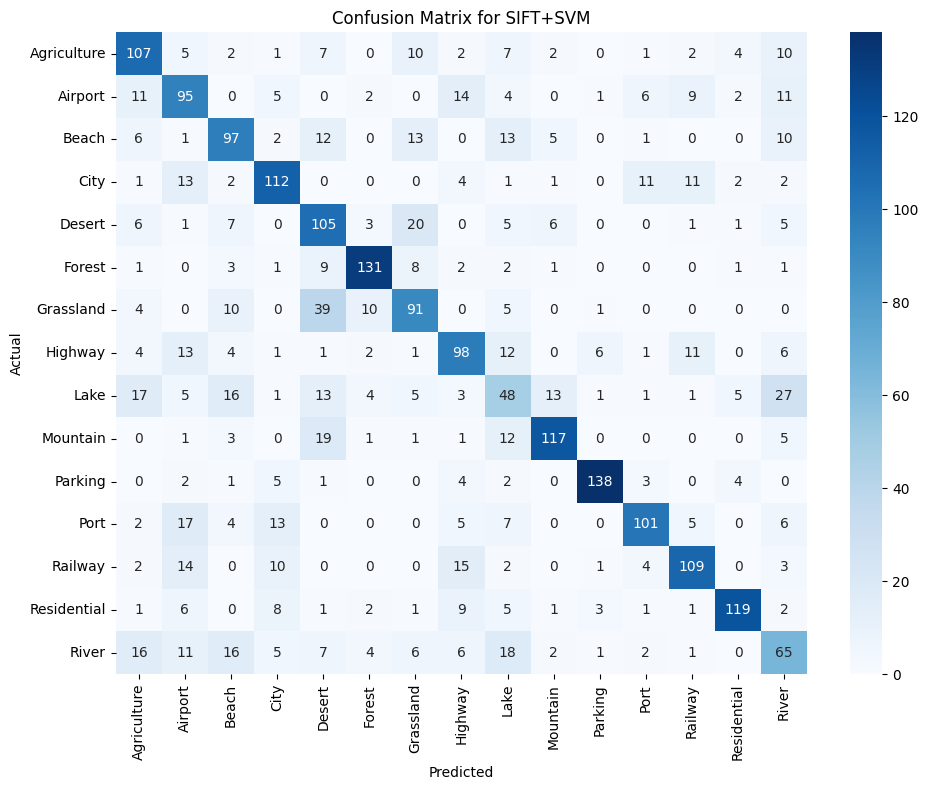

In [18]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.title("Confusion Matrix for SIFT+SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [16]:

def augment_image(img):
    if np.random.rand() > 0.5:
        img = cv2.flip(img, 1)
    angle = np.random.uniform(-15, 15)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

def load_images_with_augmentation(base_path):
    train_images, test_images = [], []
    train_labels, test_labels = [], []
    for cls_name in sorted(os.listdir(base_path)):
        cls_folder = os.path.join(base_path, cls_name)
        if os.path.isdir(cls_folder):
            all_imgs = sorted([os.path.join(cls_folder, f) for f in os.listdir(cls_folder) if f.endswith('.jpg') or f.endswith('.png')])
            random.shuffle(all_imgs)
            n_total = len(all_imgs)
            n_train = int(0.8 * n_total)
            for path in all_imgs[:n_train]:
                img = cv2.imread(path)
                train_images.append(img)
                train_images.append(augment_image(img.copy()))
                train_labels.append(class_to_idx[cls_name])
                train_labels.append(class_to_idx[cls_name])
            for path in all_imgs[n_train:]:
                img = cv2.imread(path)
                test_images.append(img)
                test_labels.append(class_to_idx[cls_name])
    return train_images, train_labels, test_images, test_labels


In [19]:
svm = SVC(kernel='linear')  
svm.fit(X_train, y_train)


def add_gaussian_noise(img, mean=0, std=20):
    noise = np.random.normal(mean, std, img.shape).astype(np.uint8)
    return cv2.add(img, noise)

def apply_blur(img, ksize=(7,7)):
    return cv2.GaussianBlur(img, ksize, 0)

def add_occlusion(img, size=40):
    h, w, _ = img.shape
    x = np.random.randint(0, w - size)
    y = np.random.randint(0, h - size)
    img[y:y+size, x:x+size] = 0
    return img

def evaluate_robustness(test_images, test_labels, transform_func, label=""):
    transformed = [transform_func(img.copy()) for img in test_images]
    test_desc = extract_sift_gray(transformed)
    X_test = build_bow_features(test_desc, kmeans)
    y_pred = svm.predict(X_test)
    print(f"\n--- Robustness testing：{label} ---")
    print(classification_report(test_labels, y_pred))

evaluate_robustness(test_images, test_labels, add_gaussian_noise, "Gaussian noise")
evaluate_robustness(test_images, test_labels, apply_blur, "Gaussian blur")
evaluate_robustness(test_images, test_labels, add_occlusion, "occlusion")



--- Robustness testing：Gaussian noise ---
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       160
           1       0.12      0.01      0.01       160
           2       0.22      0.10      0.14       160
           3       0.00      0.00      0.00       160
           4       0.10      0.01      0.02       160
           5       0.06      0.26      0.09       160
           6       0.09      0.86      0.16       160
           7       0.00      0.00      0.00       160
           8       0.03      0.01      0.01       160
           9       0.00      0.00      0.00       160
          10       0.00      0.00      0.00       160
          11       0.50      0.01      0.01       160
          12       1.00      0.01      0.01       160
          13       0.00      0.00      0.00       160
          14       0.00      0.00      0.00       160

    accuracy                           0.08      2400
   macro avg       0.16      0.08    

/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Image 3 extraction failed
Image 5 extraction failed
Image 44 extraction failed
Image 65 extraction failed
Image 89 extraction failed
Image 647 extraction failed
Image 650 extraction failed
Image 656 extraction failed
Image 657 extraction failed
Image 659 extraction failed
Image 662 extraction failed
Image 666 extraction failed
Image 669 extraction failed
Image 671 extraction failed
Image 673 extraction failed
Image 675 extraction failed
Image 691 extraction failed
Image 692 extraction failed
Image 693 extraction failed
Image 695 extraction failed
Image 701 extraction failed
Image 728 extraction failed
Image 731 extraction failed
Image 735 extraction failed
Image 746 extraction failed
Image 747 extraction failed
Image 748 extraction failed
Image 756 extraction failed
Image 757 extraction failed
Image 760 extraction failed
Image 762 extraction failed
Image 764 extraction failed
Image 780 extraction failed
Image 786 extraction failed
Image 807 extraction failed
Image 829 extraction failed

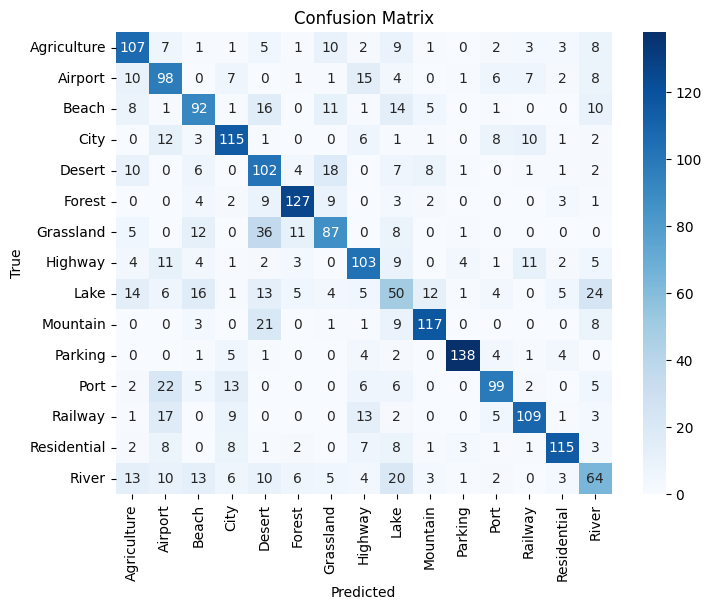

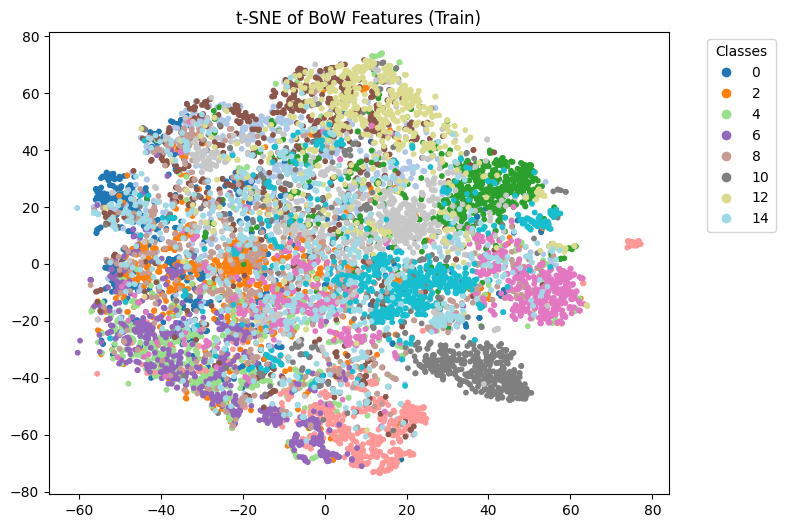

In [24]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(test_labels, svm.predict(X_test), classes)

def visualize_bow_features(X, y, title):
    tsne = TSNE(n_components=2, random_state=42)
    X_2d = tsne.fit_transform(X)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab20', s=10)
    plt.legend(*scatter.legend_elements(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes")
    plt.title(title)
    plt.show()

visualize_bow_features(np.array(X_train), y_train, "t-SNE of BoW Features (Train)")
